<a href="https://colab.research.google.com/github/limjustin/do_it_deep_learning/blob/master/Chapter07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07-1 여러 개의 이미지를 분류하는 다층 신경망 만들기

#### 다중 분류 신경망
**핵심 개념**
- 소프트맥스(softmax) 함수
- 크로스 엔트로피(cross-entropy) 손실 함수

**개념**
- 이진 분류에서는 출력층에 하나의 뉴런을 두었지만, 다중 분류에서는 출력층에 **여러 개의 뉴런**을 놓으면 됨
- 출력층에 **분류할 클래스 개수만큼** 뉴런을 배치

**주의점 및 해결방안**
- 활성화 출력의 합이 1이 아니면 비교하기 어렵
- 소프트맥스 함수 : 출력층의 출력 강도를 정규화해 줌 **(=전체 출력값의 합을 1로 만든다는 의미)**
- **최종 목표** : 도출된 확률 값을 이용하여 가중치와 절편을 업데이트하기 위한 손실 함수가 필요 -> 이 손실 함수는 '크로스 엔트로피'를 사용할 것임


#### 크로스 엔트로피 손실 함수
**개념**
- 로지스틱 손실 함수의 '일반화 버전'
- 로지스틱 손실 함수는 크로스 엔트로피 손실 함수의 이진 분류 버전
  - 크로스 엔트로피 손실 함수의 시그마 기호만 빼고, 양성 클래스와 음성 클래스에 대해 나누어 놓은 것임
- **크로스 엔트로피 손실 함수의 미분 결과는 로지스틱 손실 함수의 미분 결과와 동일함**

#### 다중 분류 신경망 구현

In [33]:
class MultiClassNetwork:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units    # 은닉층의 뉴런 개수
    self.batch_size = batch_size    # 배치 크기
    self.w1 = None    # 은닉층의 가중치
    self.b1 = None    # 은닉층의 절편
    self.w2 = None    # 출력층의 가중치
    self.b2 = None    # 출력층의 절편
    self.a1 = None    # 은닉층의 활성화 출력
    self.losses = []    # 훈련 손실
    self.val_losses = []    # 검증 손실
    self.lr = learning_rate   # 학습률
    self.l1 = l1    # L1 손실 하이퍼파라미터
    self.l2 = l2    # L2 손실 하이퍼파라미터

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1   # 첫 번째 층의 선형식 계산
    self.a1 = self.sigmoid(z1)    # 활성화 함수 적용
    z2 = np.dot(self.a1, self.w2) + self.b2   # 두 번째 층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x)    # 샘플 개수
    # 출력층의 가중치와 절편에 대한 그레이디언트 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    # 시그모이드 함수까지 그레이디언트 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    # 은닉층의 가중치와 절편에 대한 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis = 0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))    # 시그모이드 계산
    return a

  def softmax(self, z):
    # 소프트맥스 함수
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis = 1).reshape(-1, 1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))    # (특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units)    # 은닉층의 크기
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])   # 은닉층과 출력층의 가중치 초기화
    # epochs 만큼 반복
    for i in range(epochs):
      loss = 0
      print('.', end='')
      # 제너레이터 함수에서 반환한 미니 배치를 순환
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        # 안전한 로그 계산을 위한 클리핑
        a = np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        loss += np.sum(-y_batch*np.log(a))
      self.losses.append((loss+self.reg_loss()) / len(x))
      # 검증 세트에 대한 손실 계산
      self.update_val_loss(x_val, y_val)

  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size   # 미니 배치 횟수
    if length % self.batch_size:
      bins += 1   # 나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x)))    # 인덱스 섞기
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]    # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y):
    m = len(x)    # 샘플 개수 저장
    z = self.forpass(x)   # 정방향 계산 수행
    a = self.softmax(z)   # 활성화 함수 적용
    err = -(y - a)    # 오차 계산
    # 오차를 역전파하여 그레이디언트 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    # 그레이디언트에서 페널티 항의 미분값 빼기
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    # 은닉층의 가중치와 절편을 업데이트
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    # 출력층의 가중치와 절편을 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)   # 정방향 계산 수행
    return np.argmax(z, axis=1)   # 가장 큰 값의 인덱스 반환

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self):
    # 은닉층과 출력층의 가중치에 규제를 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
    self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)   # 정방향 계산 수행
    a = self.softmax(z)   # 활성화 함수 적용
    a = np.clip(a, 1e-10, 1-1e-10)    # 출력값 클리핑
    # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가
    val_loss = np.sum(-y_val * np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

#### 의류 이미지 분류 및 준비
- MNIST 데이터 세트 사용

In [4]:
## 1. 텐서플로 임포트 및 버전 확인

import tensorflow as tf
tf.__version__

'2.0.0'

In [5]:
## 2. 패션 MNIST 데이터 세트 불러오기

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
## 3. 훈련 세트의 크기 확인하기

print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


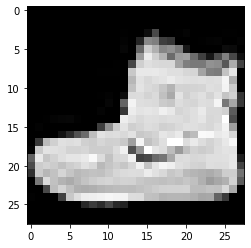

In [10]:
## 4. imshow() 함수로 샘플 이미지 확인하기

import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [14]:
## 5. 타깃의 내용과 의미 확인하기

print(y_train_all[:10])

class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])

[9 0 0 3 0 2 7 2 5 5]
앵클부츠


In [16]:
## 6. 타깃 분포 확인하기

import numpy as np
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [20]:
## 7. 훈련 세트와 검증 세트 고르게 나누기

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [21]:
## 8. 입력 데이터 정규화하기

x_train = x_train / 255
x_val = x_val / 255

In [22]:
## 9. 훈련 세트와 검증 세트의 차원 변경하기

x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

## MultiClassNetwork는 1차원 배열의 샘플을 기대하기 때문에, 이를 1차원 배열로 바꿔주어야 함

print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


#### 타깃 데이터를 준비하고 다중 분류 신경망 훈련

```
1. 타깃을 원-핫 인코딩으로 변환하기
이유
- 출력 뉴런의 개수가 10개가 되어야 하는데, y_train, y_val에 저장된 값은 정수 값 하나로 10개의 출력 뉴런에 대응되지 않음
- 타깃의 정수 값에 해당하는 원소는 1, 나머지 원소는 모두 0으로 하여 10개의 원소를 가진 배열로 크기를 늘리는 방법을 사용
- 이를 원-핫 인코딩(one-hot encoding)이라고 함
- 타깃값을 가지고 있는 1차원 정수 배열을 2차원 배열로 만들 수 있음
```


In [23]:
## 2. to_categorical 함수 사용하여 원-핫 인코딩하기 예시

tf.keras.utils.to_categorical([0, 1, 3])    # but 문자열로 된 레이블은 인코딩 불가

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [25]:
## 3. to_categorical 함수 사용하여 원-핫 인코딩하기

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [34]:
## 4. MultiClassNetwork 클래스로 다중 분류 신경망 훈련하기

fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

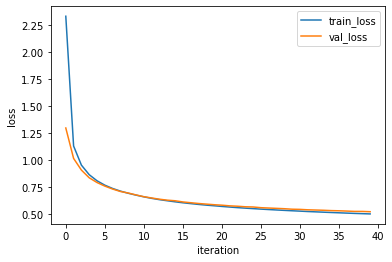

0.8150833333333334

In [37]:
## 5. 훈련 손실, 검증 손실 그래프와 훈련 모델 점수 확인하기

plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

fc.score(x_val, y_val_encoded)

## 07-2. 텐서플로와 케라스를 사용하여 신경망 만들기

#### 케라스는 무엇인가
**개념**
- 딥러닝 패키지를 편리하게 사용하기 위해 만들어진 Wrapper 패키지
- 구글은 케라스를 아예 텐서플로 안에 포함시킴

**케라스의 장점**
- 직관적으로 인공신경망의 층을 설계 가능
- Sequential 클래스 : **인공신경망 모델**을 만드는 역할 (순차적으로 층을 쌓은 신경망 **모델**)
- Dense 클래스 : **완전 연결층**을 만드는 역할 (모델에 포함된 **완전 연결층**)
- 즉, **모델과 층이 명확하게 구분**됨

#### Sequential 클래스의 기초 사용 방법
**Sequential 객체에 층을 추가하는 방법**
```
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential([Dense(...), ...])  # 객체를 생성할 때 Dense 클래스로 만든 층을 추가할 수 있음
```

**add() 메서드를 사용해 층을 추가하는 방법**
```
model = Sequential()
model.add(Dense(...))  # add 메서드를 사용하여 전달 가능
model.add(Dense(...))
```

#### Dense 클래스의 사용 방법
**뉴런의 개수를 지정하는 매개변수 unit**
```
Dense(unit=100, ...)  # 은닉층의 뉴런 개수
```

**활성화 함수를 지정하는 매개변수 activation**
```
Dense(100, activation='sigmoid')  # 활성화 함수 종류 지정 (Default : None)
```

#### 모델의 최적화 알고리즘과 손실 함수 설정하기
**목적**
- 모델을 훈련하기 위해서는 **최적화 알고리즘**이나 **손실 함수**를 지정해야 함
- 다중 분류의 최적화 알고리즘 : **경사 하강법 알고리즘**
- 다중 분류의 손실 함수 : **크로스 엔트로피 손실 함수**

**최적화 알고리즘을 지정하는 매개변수 optimizer**
```
model.compile(optimizer='sgd', ...)  # 최적화 알고리즘은 매개변수 optimizer를 사용
                                     # 'sgd'로 지정하면 기본 경사 하강법을 최적화 알고리즘으로 사용
```

**손실 함수를 지정하는 매개변수 loss**
```
model.compile(optimizer='sgd', loss='categorical_crossentropy')

## 제곱 오차 : loss의 매개 변수는 'mse'
## 로지스틱 손실 함수 : 'binary_crossentropy'
## 크로스 엔트로피 손실 함수 : 'categorical_crossentropy'
```

#### 최종적으로 모델을 훈련하고 예측하는 과정
```
model = Sequential()  # Sequential 클래스의 객체 생성
model.add(Dense(...))  # add() 메서드 사용하여 층을 추가
model.add(Dense(100, activation='sigmoid'))  # 뉴런의 개수와 활성화 함수 지정
model.compile(optimizer = '...', loss = '...')  # 최적화 알고리즘과 손실 함수 설정
model.fit(X, y, epochs = ...)  # 모델을 훈련하는 메서드
model.predict(X)  # 모델을 예측하는 메서드
model.evaluate(X, y)  # 모델을 평가하는 메서드
```

#### 케라스로 다중 분류 신경망 만들어보기

In [38]:
## 1. 모델 생성하기

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()    # Sequential 객체 생성

In [39]:
## 2. 은닉층과 출력층을 모델에 추가하기

model.add(Dense(100, activation='sigmoid', input_shape=(784,)))   # 은닉층의 유닛 개수 : 100개 / 활성화 함수 : 시그모이드 함수 / 입력 데이터 개수 : 784개(28*28)
model.add(Dense(10, activation='softmax'))    # 출력층의 유닛 개수 : 10개 / 활성화 함수 : 소프트맥스 함수

In [40]:
## 3. 최적화 알고리즘과 손실 함수 지정하기

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
## 최적화 알고리즘 : 경사 하강법 (sgd)
## 손실 함수 : 크로스 엔트로피 손실 함수 (categorical_crossentropy)
## metrics 매개변수 : 모델을 훈련하며 기록한 정보를 History 객체에 담아 반환하는데,
##                    Default는 손실값(loss)을 기록. 모델의 정확도에 대한 기록을 살펴보려면 'accuracy'를 추가해야 함

In [41]:
## 4. 모델 훈련하기

history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))
## 40번의 에포크 동안 훈련 진행
## 훈련하는 도안 검증 세트에 대한 손실과 정확도를 계산
## validation_data 매개변수에 검증 세트를 튜플로 전달하여 이를 진행
## fit() 메서드는 훈련 세트와 검증 세트에서 측정한 값들을 History 클래스 객체(history)에 담아 반환

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 4s 85us/sample - loss: 1.3737 - accuracy: 0.6480 - val_loss: 0.9485 - val_accuracy: 0.7366
Epoch 2/40
48000/48000 [==============================] - 3s 72us/sample - loss: 0.8332 - accuracy: 0.7446 - val_loss: 0.7477 - val_accuracy: 0.7573
Epoch 3/40
48000/48000 [==============================] - 3s 72us/sample - loss: 0.7083 - accuracy: 0.7641 - val_loss: 0.6639 - val_accuracy: 0.7773
Epoch 4/40
48000/48000 [==============================] - 3s 72us/sample - loss: 0.6459 - accuracy: 0.7787 - val_loss: 0.6137 - val_accuracy: 0.7906
Epoch 5/40
48000/48000 [==============================] - 3s 72us/sample - loss: 0.6048 - accuracy: 0.7932 - val_loss: 0.5784 - val_accuracy: 0.8028
Epoch 6/40
48000/48000 [==============================] - 3s 71us/sample - loss: 0.5745 - accuracy: 0.8034 - val_loss: 0.5520 - val_accuracy: 0.8112
Epoch 7/40
48000/48000 [==============================] 

In [42]:
## 5. history 딕셔너리의 측정 지표

print(history.history.keys())
## loss : 훈련 세트의 손실
## accuracy : 훈련 세트의 정확도
## val_loss : 검증 세트의 손실
## val_accuracy : 검증 세트의 정확도

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


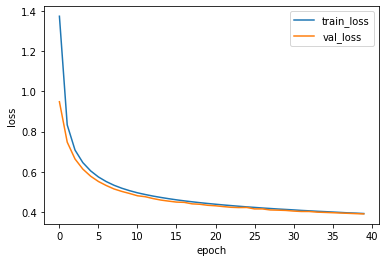

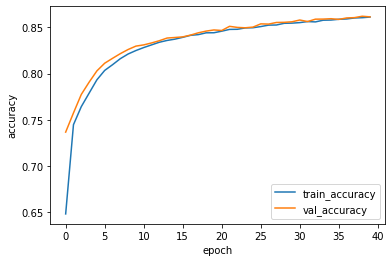

In [44]:
## 6. 훈련 세트와 검증 세트의 손실 그래프와 정확도

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [47]:
## 7. 검증 세트 정확도 계산하기

loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)   # 위에서 구현한 MultiClassNetwork에 비해 성능이 증가하긴 함
## 이미지 데이터에 잘 맞는 모델은 합성곱 신경망(convolution neural network)

0.8613333
